In [1]:
################
# IMPORTING DATA
################
import numpy as np
import pandas as pd
import datetime
from pyomo.environ import *
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.figure import Figure 
from datetime import datetime

# Import data for optimization
file1 = 'Dataframe_2019_MW.csv'
df1 = pd.read_csv(file1)
XGB = pd.read_csv('HOEP_2019_forecast_XGB1.csv')

# Create a column of index for hour. There is already a column called "HOUR" but this new one will be used 
# as an index for the optimization
df1['hour'] = range(0, len(df1.Hour))
df1['ClassA'] = (df1.MktDem)/3500 # To get an approximation of the hourly consumption of a University Building
df1['XGB'] = XGB.Forecast
df1 = df1.drop(columns=['TOU_N', 'TOU', 'TOU_Year'])
# This operation was performed to filter the data in order to keep only a day or a week of the data prior to this.
# Now we will try with the whole year 2019 dataset.
df = df1

df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.strftime('%m')
df['Datetime'] = pd.to_datetime(df.Date) + pd.to_timedelta(df.Hour, unit='h')

# GLOBAL ADJUSTMENT COSTS CALCULATION FOR THE CLASS A CONSUMER TYPE
"https://www.ieso.ca/en/Sector-Participants/Settlements/Global-Adjustment-and-Peak-Demand-Factor"
#Sum of Top 5 System-wide Consumption Peaks (MWh) between May 2019 and April 2020
five_peaks_GA = ['2019-07-29 17:00:00', '2019-07-05 17:00:00','2019-07-20 17:00:00',
                 '2019-07-19 12:00:00','2019-07-04 18:00:00']
AQEW_2019 = sum(df.loc[df['Datetime'].isin(five_peaks_GA)].OntDem)
ClassA_peaks_2019 = sum(df.loc[df['Datetime'].isin(five_peaks_GA)].ClassA)
Peak_demand_factor_ClassA = ClassA_peaks_2019/AQEW_2019  #Peak_demand_factor for a 5MW average peak demand consumer

# TOTAL GLOBAL ADJUSTMENT Monthly CHARGE FOR ClassA consumer summed to get annual charge
GA_Month_2019 = np.array([956.2, 908.1, 857.6, 1118.7, 1133.3, 1261.3, 1149.6, 1327.7, 1082.9, 
                          1209.6, 979.0, 1000.2])
Sum_GA_2019 = sum(GA_Month_2019*1000000)
Sum_GA_costs_ClassA_2019 = Sum_GA_2019  *Peak_demand_factor_ClassA #To get the GA_total costs in $ instead of millions $

df.loc[df['Datetime'].isin(five_peaks_GA)]

,Date,Hour,MktDem,OntDem,HOEP,Season,Weekday,hour,ClassA,XGB,Month,Datetime
4433,2019-07-04,18,23340,21423,24.26,1,3,4433,6.668571,17.774033,07,2019-07-04 18:00:00
4456,2019-07-05,17,24177,21716,32.97,1,4,4456,6.907714,21.347692,07,2019-07-05 17:00:00
4787,2019-07-19,12,23638,21545,27.60,1,4,4787,6.753714,26.085625,07,2019-07-19 12:00:00
4816,2019-07-20,17,22944,21480,60.28,1,5,4816,6.555429,24.395393,07,2019-07-20 17:00:00
5032,2019-07-29,17,24561,21791,41.83,1,0,5032,7.017429,28.865622,07,2019-07-29 17:00:00


<ipython-input-2-855714cd0b78>:20: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(('Demande Ontario', 'Demande simulée'), loc='best', frameon=False)


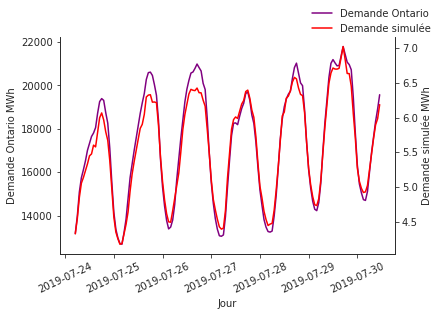

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import seaborn as sns

M_dem = df.groupby(['Month'], as_index=False)['ClassA'].max()
M_dem.append(M_dem.mean().rename('Avg'))

df_subset = df.loc[4900:5050]  # choose part of data to illustrate it

with sns.axes_style("ticks", {"grid.color": "white"}):
    ax1 = sns.set_style(style=None, rc=None )
    fig, ax1 = plt.subplots()
    g = sns.lineplot(data=df_subset,x='Datetime', y='OntDem',color="purple",legend='full',ax=ax1,zorder=1)
    plt.ylabel("Demande Ontario MWh")
    plt.xlabel('Jour')
    plt.xticks(rotation=25)
    ax2 = ax1.twinx()
    g = sns.lineplot(data=df_subset,x='Datetime', y='ClassA', color="red",legend='full',ax=ax2,zorder=2)
    fig.legend(('Demande Ontario', 'Demande simulée'), loc='best', frameon=False)
    plt.ylabel('Demande simulée MWh')
    sns.despine(top=True, right=False)
    #plt.savefig('Simulated_Demand', dpi=1200, bbox_inches='tight')

In [3]:
##### COSTS MINIMIZATION WITH PERFECT FORESIGHT of the price ####
################################################################
start_time = datetime.now()

import numpy as np
import pandas as pd
from pyomo.environ import *

model = ConcreteModel()

# Define model parameters
model.T = Set(initialize=df.hour.tolist(), ordered=True)
model.Rmax = Var(within=PositiveReals) # variable in the first stage optimization
model.Smax = Var(within=PositiveReals) # variable in the first stage optimization
model.Eout = Var(model.T, domain=NonNegativeReals)
model.Ein = Var(model.T, domain=NonNegativeReals) 
model.Z = Var(model.T, domain=NonNegativeReals)  
model.L = Var(model.T) 
model.eta = Param(initialize=0.86)
model.value = Var(model.T)
c_rate = 1/3 # used as the constraint on number of hours
# The c_rate is the invert of the number of hours of storage. C_rate 0.33 = 3h of storage.
# The gets all results presented in tables 5.7, 5.9 and 5.10, we chose different values for c_rate to 
# assess sensibility to hours of storage. C_rate values of 0.25, 0.33, 0.5 and 1 were tested which is the same
# as hours of storage = 1,2,3,4

#######################################
# DEFINE ALL CONSTRAINTS OF THE MODEL#
#####################################
"Initial storage state = 0 and constraint on SOC flow"
def storage_state(model, t):
    if t == model.T.first():
        return model.Z[t] == 0
    else:
        return model.Z[t] == (model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t])                             
model.charge_state = Constraint(model.T, rule=storage_state)

"Max SOC constraint"   
def SOC_maxconstraint(model, t):
    return model.Z[t] <= model.Smax
model.SOC_maxconstraint = Constraint(model.T, rule=SOC_maxconstraint)

"Min SOC constraint"   
def SOC_minconstraint(model, t):
    return model.Z[t] >= 0
model.SOC_minconstraint = Constraint(model.T, rule=SOC_minconstraint)

"Maximum dischage within a single hour"
def discharge_constraint(model, t):
    return model.Eout[t] <= model.Rmax
model.discharge = Constraint(model.T, rule=discharge_constraint)

"Maximum dischage within a single hour"
def charge_constraint(model, t):
    return model.Ein[t] <= model.Rmax
model.charge = Constraint(model.T, rule=charge_constraint)

"Demand of energy constraint"
def demand_constraint(model, t):
    return model.L[t] == df.loc[t, 'ClassA'] + model.Ein[t] - model.Eout[t]
model.demand_constraint = Constraint(model.T, rule=demand_constraint)

"Non-negativity of total demand"
def negativity_demand_constraint(model, t):
    return model.L[t] >= 0
model.negativity_demand_constraint = Constraint(model.T, rule=negativity_demand_constraint)

"C-rate, minimal number of hours of storage desired"
def c_rate_constraint(model):
    return model.Rmax <= model.Smax * c_rate
model.c_rate_constraint = Constraint(rule=c_rate_constraint)

def value_constraint(model, t):
    return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP']
model.value_constraint = Constraint(model.T, rule=value_constraint)

#########################################
# Define objective function to optimize #
#########################################
# Battery Costs
Bcosts = (model.Smax * 344000 + model.Rmax * 125000) * (0.06/(1-(1+0.06)**-5))
# Costs without storage
original_costs = sum(df.loc[t,'HOEP']*df.loc[t,'ClassA'] for t in model.T)+Sum_GA_costs_ClassA_2019
# Get PDF with storage based on index of 5 peak demand periods
Opt_peak_factor_ClassA = ((model.L[4433]+model.L[4456]+model.L[4787]+model.L[4816]+
                          model.L[5032])/AQEW_2019)
model.costs = sum(df.loc[t,'HOEP']*model.L[t] for t in model.T)+Opt_peak_factor_ClassA*Sum_GA_2019+Bcosts

model.objective = Objective(expr=model.costs, sense=minimize)

# Solve the model 
results = SolverFactory('glpk').solve(model) 
# we use GLPK here because the model is linear and GLPK is FASTER. IPOPT is used for second optimization

# Store results in lists and dataframe 
list_of_series = [  list(df.Datetime),
                    pd.Series(list(df.HOEP)),
                    pd.Series(list(df.ClassA)),
                    pd.Series(list(model.L.get_values().values())),
                    pd.Series(list(model.Ein.get_values().values())),
                    pd.Series(list(model.Eout.get_values().values())),
                    pd.Series(list(model.Z.get_values().values())), ]
df_results = pd.DataFrame(list_of_series)
df_results = df_results.T 
df_results.rename(columns={0:'Datetime',1:'HOEP',2:'ClassA',3:'L',4:'Ein',5:'Eout',6:'SOC'},
                  inplace = True) 

Investment = ((model.Smax.get_values()[None]*344000 + model.Rmax.get_values()[None]*125000)
              *(0.06/(1-(1+0.06)**-5)))
load = list(model.L.get_values().values())
Opt_GA_costs = (load[4433] + load[4456] + load[4787]+ load[4816] + load[5032])/AQEW_2019 * Sum_GA_2019

# DISPLAY RESULTS
print("running time:", datetime.now() - start_time)
print("Pre-optimized total costs:", original_costs)
print("Pre-optimized GA costs:", Sum_GA_costs_ClassA_2019)
print("Pre-optimized energy costs:", original_costs - Sum_GA_costs_ClassA_2019)
print("Optimized total costs:", round(model.objective(),2))
print("Optimized GA costs:", Opt_GA_costs)
print("Optimized energy costs:", round(sum(df_results.L * df_results.HOEP),2)) 
print("Battery costs/Investment:", Investment)
print("Internal Investment Return % =", round(((original_costs-model.objective())/original_costs)*100,2))
print("Smax:", model.Smax.get_values()[None])
print("Rmax:", model.Rmax.get_values()[None])
print("C-rate:", model.Rmax.get_values()[None]/model.Smax.get_values()[None])
print("original peak factor:", Peak_demand_factor_ClassA)
print("peak factor after optimization:", value(Opt_peak_factor_ClassA))
print("Arbitrage revenues:", sum((df_results.Eout - df_results.Ein)*df_results.HOEP))
Opt_Smax = model.Smax.get_values()[None] # Store battery capacity opt value for second optimization
Opt_Rmax = model.Rmax.get_values()[None] # Store battery power opt value for second optimization

df_results.loc[df_results['Datetime'].isin(five_peaks_GA)] # to see demand during 5 peaks after opt.

running time: 0:00:42.555336
Pre-optimized total costs: 4867001.344822029
Pre-optimized GA costs: 4077638.6245591748
Pre-optimized energy costs: 789362.7202628539
Optimized total costs: 2443739.35
Optimized GA costs: 50240.246663623104
Optimized energy costs: 538472.37
Battery costs/Investment: 1855026.7323414527
Internal Investment Return % = 49.79
Smax: 20.2611428571429
Rmax: 6.75371428571429
C-rate: 0.3333333333333328
original peak factor: 0.00031404619649721776
peak factor after optimization: 3.869337091513001e-06
Arbitrage revenues: 250890.3540659001


,Datetime,HOEP,ClassA,L,Ein,Eout,SOC
4433,2019-07-04 18:00:00,24.26,6.66857,0,0,6.66857,6.61486
4456,2019-07-05 17:00:00,32.97,6.90771,0.154,0,6.75371,6.75371
4787,2019-07-19 12:00:00,27.6,6.75371,0,0,6.75371,8.64475
4816,2019-07-20 17:00:00,60.28,6.55543,0,0,6.55543,0
5032,2019-07-29 17:00:00,41.83,7.01743,0.263714,0,6.75371,13.5074


In [4]:
##########################################################
## IMPORT AND PREPARE DATA for the second optimization ##
########################################################
import numpy as np
import pandas as pd
from datetime import datetime
from typing import List
from pyomo.environ import *

# Import data
filename1 = 'HOEP_2015-2019_dataset.csv'
XGboost_2019 = pd.read_csv('HOEP_2019_forecast_XGB1.csv')
XGboost12_2019 = pd.read_csv('HOEP_2019_forecast_XGB12.csv')

dataframe = pd.read_csv(filename1)
dataframe['HOEP_lag168'] = dataframe.HOEP.shift(168)
cols_of_interest = ["Date","Hour","Month","HOEP","OntDem","MktDem","HOEP_lag168","Temp(C)"]
dataframe = dataframe[cols_of_interest]

dataframe = dataframe.append(dataframe.loc[35064:35064+167], ignore_index=True)
dataframe['Datetime'] = pd.to_datetime(dataframe.Date) + pd.to_timedelta(dataframe.Hour, unit='h')

df_2019 = dataframe.loc[35064:].reset_index(drop=True)
df_2019['XGB'] = list(XGboost_2019.Forecast) + list(XGboost_2019.Forecast.head(168))
df_2019['XGB12'] = list(XGboost12_2019.Forecast) + list(XGboost12_2019.Forecast.head(168))
df_2019['ClassA'] = df_2019.MktDem/3500

# add data at the end of 2019 so the algorithm has additional hours 
# of info to get optimization until the last period. Because it uses future info up to 12 periods.
dataframe = df_2019.copy()
dataframe = dataframe.fillna(0)
dataframe[dataframe['Temp(C)'].isna()] # Check for NAN values
dataframe.fillna(dataframe.groupby([dataframe.Date]).transform('mean'),inplace=True)
#fill nan values with average temp day
dataframe

,Date,Hour,Month,HOEP,OntDem,MktDem,HOEP_lag168,Temp(C),Datetime,XGB,XGB12,ClassA
0,2019-01-01,1,1,0.00,13198,16231,14.35,5.1,2019-01-01 01:00:00,0.405360,2.580984,4.637429
1,2019-01-01,2,1,0.00,12737,16051,24.19,6.2,2019-01-01 02:00:00,0.770444,5.863590,4.586000
2,2019-01-01,3,1,-0.11,12531,15805,14.39,5.6,2019-01-01 03:00:00,0.770444,5.975186,4.515714
3,2019-01-01,4,1,-1.84,12291,15580,14.39,3.2,2019-01-01 04:00:00,0.439540,4.963967,4.451429
4,2019-01-01,5,1,-0.47,12305,15609,23.40,2.7,2019-01-01 05:00:00,0.439540,5.308259,4.459714
...,...,...,...,...,...,...,...,...,...,...,...,...
8923,2019-01-07,20,1,11.97,18954,20626,5.62,0.5,2019-01-07 20:00:00,2.084059,5.337851,5.893143
8924,2019-01-07,21,1,12.73,18550,20010,8.95,1.1,2019-01-07 21:00:00,2.087170,18.612055,5.717143
8925,2019-01-07,22,1,23.49,17843,20020,5.81,1.4,2019-01-07 22:00:00,2.384926,6.018135,5.720000
8926,2019-01-07,23,1,9.68,16650,19071,2.87,1.8,2019-01-07 23:00:00,21.973452,0.788128,5.448857


In [6]:
##### COSTS MINIMIZATION WITH IMPERFECT FORESIGHT OF PRICE AND 5 PEAK DEMAND PERIODS  ####
#########################################################################################
start_time = datetime.now()

import numpy as np
import pandas as pd
from datetime import datetime
from pyomo.environ import *

data = dataframe.copy()

# Create lists to store results for each iteration
list_Date = []
list_OntDem = []
list_ClassA = []
list_HOEP = []
list_XGB = []
list_XGB12 = []
list_HOEP_lag168 = []
list_SOC = []
list_Ein = []
list_Eout = []
list_L = []
list_value = []
list_costs = []
list_Rmax = []
list_Smax = []
list_peaks = []

horizon = 167  # length of planning horizon 

for i in range(0,8760): # 8760 iterations, one every hour of the year
    
    df = data.loc[0+i:horizon+i] # used to create rolling planning horizon optimization

    model = ConcreteModel() # Create Pyomo Concrete Model

    # Define model parameters
    model.T = Set(initialize=df.index, ordered=True) # hourly index of the year
    model.Rmax = Param(initialize=Opt_Rmax) # battery power rated
    model.Smax = Param(initialize=Opt_Smax) # battery capacity rated
    model.Eout = Var(model.T, domain=NonNegativeReals) # energy discharged, d_t
    model.Ein = Var(model.T, domain=NonNegativeReals) # energy charged, c_t
    model.Z = Var(model.T, domain=NonNegativeReals)  # State of charge (SOC) of the battery 
    model.L = Var(model.T) # load
    model.value = Var(model.T) # value of energy arbitrage
    model.peaks = Var(model.T, within=Binary) # binary variable for predicted peaks
    model.eta = Param(initialize=0.86) # energy efficiency
    model.energy_costs = Var(model.T) # hourly total costs of energy (load * HOEP)

    #########################################
    # DEFINE ALL CONSTRAINTS OF THE MODEL #
    ######################################
    "Initial storage state = capacity/2 and constraint on SOC flow"
    def storage_state(model, t):
        if df['Datetime'].iloc[0] == data.Datetime.head(1).item():  
            if t == model.T.first():
                return model.Z[t] == model.Smax/2  # begin with battery charged half capacity
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
        else:
            if t == model.T.first(): # If not first iteration, SOC = SOC at the end of last period
                return model.Z[t] == SOC + model.Ein[t]*model.eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*model.eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    "Max SOC constraint"   
    def SOC_max(model, t):
        return model.Z[t] <= model.Smax
    model.SOC_max = Constraint(model.T, rule=SOC_max)

    "Min SOC constraint"   
    def SOC_min(model, t):
        return model.Z[t] >= 0
    model.SOC_min = Constraint(model.T, rule=SOC_min)

    "Maximum dischage within a single hour"
    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    "Maximum charge within a single hour"
    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    "Demand of energy constraint"
    def demand_constraint(model, t):
        return model.L[t] == (df.loc[t, 'ClassA'] + model.Ein[t] - model.Eout[t])
    model.demand_constraint = Constraint(model.T, rule=demand_constraint)

    "Non-negativity of total demand" # means that cannot sell energy to the grid
    def negativity_demand_constraint(model, t):
        return  model.L[t] >= 0
    model.negativity_demand_constraint = Constraint(model.T, rule=negativity_demand_constraint)
    
    "Constraint used to compute energy arbitrage value"
    def value_constraint(model, t): # which price forecast is used and when
        if t == model.T.first():
            return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB']
        else:
            if t in range(1,12):
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'XGB12']
            else:
                return model.value[t] == (model.Eout[t] - model.Ein[t]) * df.loc[t,'HOEP_lag168']     
    model.value_constraint = Constraint(model.T, rule=value_constraint)

    "Enforce discharging during forecasted peak hours of the year"
    def peak_hours(model, t):
        if df.loc[t, 'Month'] == 7 or df.loc[t, 'Month'] == 9: # Months of summer: july and september
            if df.loc[t, 'Hour'] in range(17,20) or df.loc[t, 'Hour'] in range(12,14):#Hour: 17-19 or 12-13
                if df.loc[t, 'Temp(C)'] >= 26:
                    return model.peaks[t] == 1
                else:
                    return model.peaks[t] == 0
            else:
                return model.peaks[t] == 0 
        elif df.loc[t, 'Month'] == 1 or df.loc[t, 'Month'] == 2: # during winter: January of february
            if df.loc[t, 'Hour'] in range(18,21):                # between 18:00 - 20:00
                if df.loc[t, 'Temp(C)'] <= -11 or df.loc[t, 'HOEP'] >= 52:  # if temp is low or price is high
                    return model.peaks[t] == 1
                else:
                    return model.peaks[t] == 0
            else:
                return model.peaks[t] == 0
        else:
            if df.loc[t, 'Month'] == 8:                         # month of august
                if df.loc[t, 'Hour'] in range(17,18):           # if hour == 17:00:00
                    return model.peaks[t] == 1
                else:
                    return model.peaks[t] == 0
            else:
                return model.peaks[t] == 0
    model.peak_hours = Constraint(model.T, rule=peak_hours)
    
    "Constraint to get energy costs for every hour"
    def costs_constraint(model, t):
        if t == model.T.first():
            return model.energy_costs[t] == model.L[t] * df.loc[t,'XGB']
        else:
            if t in range(1,12):
                return model.energy_costs[t] == model.L[t] * df.loc[t,'XGB12']
            else:
                return model.energy_costs[t] == model.L[t] * df.loc[t,'HOEP_lag168']               
    model.costs_constraint = Constraint(model.T, rule=costs_constraint)

    ##########################################
    # Define objective function to optimize #
    #########################################
    # Objective function
    "Refer to energy costs + a cost penalty for energy demand during peak anticipated periods." 
    costs = sum(model.energy_costs[t] + model.L[t]*model.peaks[t]*100000 for t in model.T)
    model.objective = Objective(expr=costs, sense=minimize)
    
    # Solve the model
    solver = SolverFactory('ipopt')
    solver.solve(model) 
    
    # Extract model output in lists and store results of the first hour only
    Date = list(df['Datetime'])[0]
    HOEP = list(df['HOEP'])[0]
    OntDem= list(df['OntDem'])[0]
    ClassA= list(df['ClassA'])[0]
    XGB = list(df['XGB'])[0]
    XGB12 = list(df['XGB12'])[0]
    HOEP_lag168 = list(df['HOEP_lag168'])[0]
    SOC = list(model.Z.get_values().values())[0]
    Load = list(model.L.get_values().values())[0]
    Ein= list(model.Ein.get_values().values())[0]
    Eout = list(model.Eout.get_values().values())[0]
    value = list(model.value.get_values().values())[0]
    peaks = list(model.peaks.get_values().values())[0]
    
    # Append results of single hour to previous iterations results
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_OntDem.append(OntDem)
    list_ClassA.append(ClassA)
    list_XGB.append(XGB)
    list_XGB12.append(XGB12)
    list_HOEP_lag168.append(HOEP_lag168)
    list_SOC.append(SOC)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_L.append(Load)
    list_value.append(value)
    list_peaks.append(peaks)

# Present final results in a dataframe
results = pd.DataFrame(list_Date, columns=['Datetime'])
results['Load'] = list_L
results['HOEP'] = list_HOEP
results['OntDem'] = list_OntDem
results['ClassA'] = list_ClassA
results['XGB'] = list_XGB
results['XGB12'] = list_XGB12
results['Ein'] = list_Ein
results['Eout'] = list_Eout
results['SOC'] = list_SOC
results['Peaks'] = list_peaks
results['value'] = list_value
results['real_value'] = (results.Eout - results.Ein)*results.HOEP
results = results.copy()

# Capital costs of battery
P_Rmax = 125000
P_Smax = 344000
Investment = (Opt_Smax*P_Smax + Opt_Rmax*P_Rmax)*(0.06/(1-(1+0.06)**-5))

# Compute global adjustment costs after optimization
Opt_GA_costs_rolling = (sum(results.loc[results['Datetime'].isin(five_peaks_GA)].Load)
                                                            /AQEW_2019 * Sum_GA_2019)
# Energy costs after optimization
Energy_costs = sum(results.Load * results.HOEP)

# Total costs after optimization
Total_opt_costs_rolling = Investment + Opt_GA_costs_rolling + Energy_costs

# DISPLAY RESULTS
print("Pre-optimized total costs:", original_costs)
print("Pre-optimized GA costs:", Sum_GA_costs_ClassA_2019)
print("Pre-optimized energy costs:", original_costs - Sum_GA_costs_ClassA_2019)
print("Optimized total costs:", Total_opt_costs_rolling)
print("Optimized GA costs:", Opt_GA_costs_rolling)
print("Optimized energy costs:", round(Energy_costs,2)) 
print("Battery costs/Investment:", Investment)
print("Internal Invest. Return% =",round(((original_costs-Total_opt_costs_rolling)/original_costs)*100,2))
print("Arbitrage revenues:", sum(results.real_value))
print("Smax:", Opt_Smax)
print("Rmax:", Opt_Rmax)
print("Hours of storage:", Opt_Smax/Opt_Rmax)
print("original PDF:", Peak_demand_factor_ClassA)
print("PDF after:", sum(results.loc[results['Datetime'].isin(five_peaks_GA)].Load)/AQEW_2019)
print("running time:", datetime.now() - start_time)
results.loc[results['Datetime'].isin(five_peaks_GA)] # to show the final demand of energy during the 5 
                                                     # unforseen peaks of demand  

Pre-optimized total costs: 4867001.344822029
Pre-optimized GA costs: 4077638.6245591748
Pre-optimized energy costs: 789362.7202628539
Optimized total costs: 2607041.903483166
Optimized GA costs: 50240.22440397884
Optimized energy costs: 701774.95
Battery costs/Investment: 1855026.7323414527
Internal Invest. Return% = 46.43
Arbitrage revenues: 87587.77300727674
Smax: 20.2611428571429
Rmax: 6.75371428571429
Hours of storage: 3.0000000000000044
original PDF: 0.00031404619649721776
PDF after: 3.869335377149061e-06
running time: 0:18:24.271469


,Datetime,Load,HOEP,OntDem,ClassA,XGB,XGB12,Ein,Eout,SOC,Peaks,value,real_value
4433,2019-07-04 18:00:00,-9.999975e-09,24.26,21423,6.668571,17.774033,22.891769,0.0,6.668571,6.614857,1.0,118.527406,161.779543
4456,2019-07-05 17:00:00,1.539999e-01,32.97,21716,6.907714,21.347692,16.875340,0.0,6.753714,13.386286,1.0,144.176217,222.669962
4787,2019-07-19 12:00:00,-9.999975e-09,27.60,21545,6.753714,26.085625,24.763906,0.0,6.753714,13.507429,1.0,176.174856,186.402514
4816,2019-07-20 17:00:00,-9.999975e-09,60.28,21480,6.555429,24.395393,23.858755,0.0,6.555429,12.928571,1.0,159.922259,395.161234
5032,2019-07-29 17:00:00,2.637142e-01,41.83,21791,7.017429,28.865622,38.697952,0.0,6.753714,13.507429,1.0,194.950163,282.507871
